True Click-Through Rates (CTR) per Ad: [0.22 0.48 0.38 0.32 0.12 0.12 0.08 0.44 0.32 0.37]


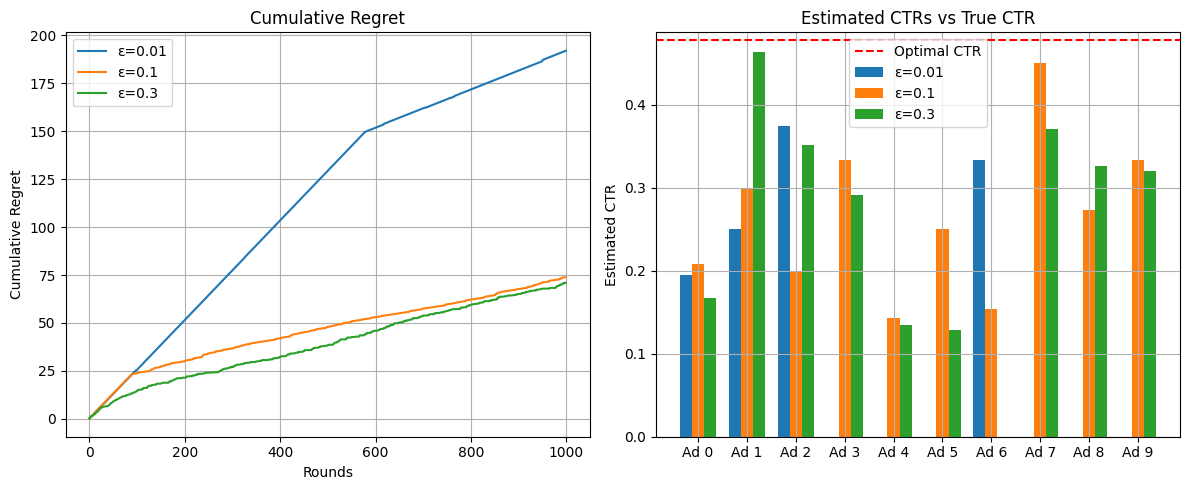

In [3]:
import numpy as np
import matplotlib.pyplot as plt

class EpsilonGreedyAgent:
    def __init__(self, n_arms, epsilon):
        self.n_arms = n_arms
        self.epsilon = epsilon
        self.counts = np.zeros(n_arms)  # Number of times each arm was pulled
        self.values = np.zeros(n_arms)  # Estimated value (CTR) for each arm
        self.total_reward = 0
        self.actions = []
        self.rewards = []

    def select_action(self):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.n_arms)  # Explore
        else:
            return np.argmax(self.values)  # Exploit

    def update(self, action, reward):
        self.counts[action] += 1
        self.values[action] += (reward - self.values[action]) / self.counts[action]
        self.total_reward += reward
        self.actions.append(action)
        self.rewards.append(reward)

def simulate_bandit(true_ctrs, epsilon, n_rounds=1000):
    n_arms = len(true_ctrs)
    agent = EpsilonGreedyAgent(n_arms, epsilon)
    optimal_arm = np.argmax(true_ctrs)
    regrets = []

    for t in range(n_rounds):
        action = agent.select_action()
        reward = np.random.rand() < true_ctrs[action]
        agent.update(action, reward)
        regret = true_ctrs[optimal_arm] - true_ctrs[action]
        regrets.append(regret)

    return agent, np.cumsum(regrets)

# ---------- Main Experiment ----------

np.random.seed(42)
n_arms = 10
true_ctrs = np.random.uniform(0.05, 0.5, n_arms)
print("True Click-Through Rates (CTR) per Ad:", np.round(true_ctrs, 2))

n_rounds = 1000
epsilons = [0.01, 0.1, 0.3]
agents = {}
regret_curves = {}

for epsilon in epsilons:
    agent, regrets = simulate_bandit(true_ctrs, epsilon, n_rounds)
    agents[epsilon] = agent
    regret_curves[epsilon] = regrets

# ---------- Plotting Results ----------

plt.figure(figsize=(12, 5))

# Plot cumulative regret
plt.subplot(1, 2, 1)
for epsilon in epsilons:
    plt.plot(regret_curves[epsilon], label=f'ε={epsilon}')
plt.title("Cumulative Regret")
plt.xlabel("Rounds")
plt.ylabel("Cumulative Regret")
plt.legend()
plt.grid(True)

# Plot estimated CTRs vs true CTRs
plt.subplot(1, 2, 2)
bar_width = 0.25
x = np.arange(n_arms)
for i, epsilon in enumerate(epsilons):
    plt.bar(x + i * bar_width,
            agents[epsilon].values,
            width=bar_width,
            label=f'ε={epsilon}')
plt.axhline(np.max(true_ctrs), color='r', linestyle='--', label='Optimal CTR')
plt.xticks(x + bar_width, [f'Ad {i}' for i in range(n_arms)])
plt.ylabel("Estimated CTR")
plt.title("Estimated CTRs vs True CTR")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Tasks

-> Simulate multiple user segments (e.g., teenagers, adults, seniors) where each segment has a different CTR distribution per ad. Modify the bandit logic to include user context and switch εgreedy to contextual bandit.

-> Implement per-ad budget (e.g., only 100 displays allowed for premium ads). The agent must learn to prioritize high-reward ads while respecting budget constraints. Extend reward logic to penalize exceeding limits

-> Implement three different strategies – ε-Greedy, UCB, and Softmax Selection – on the same ad simulation environment. Record cumulative reward and plot average regret. Evaluate which performs best under CTR drift.

Simulating agent: ε-Greedy
Simulating agent: UCB
Simulating agent: Softmax


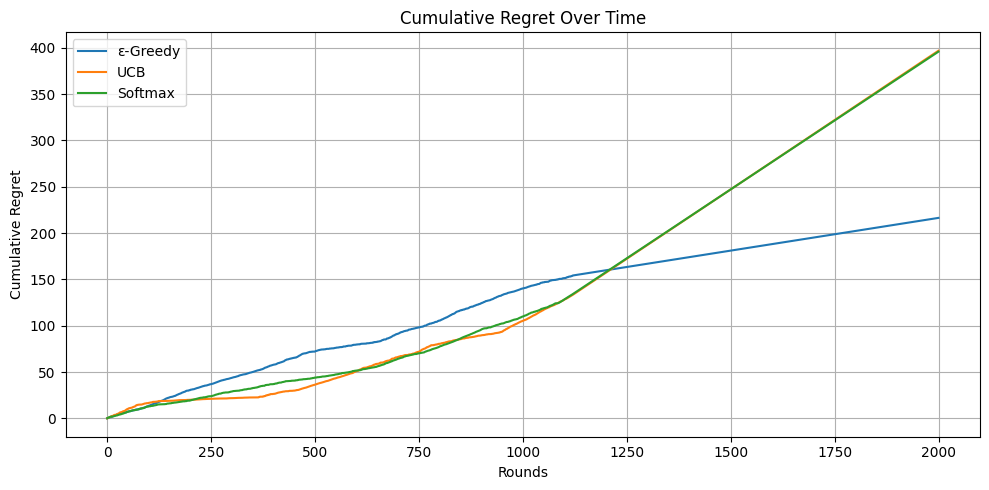

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------
# Simulated Environment Setup
# ---------------------------

class AdEnvironment:
    def __init__(self, n_ads, n_segments, budgets, ctrs_per_segment):
        self.n_ads = n_ads
        self.n_segments = n_segments
        self.budgets = budgets.copy()
        self.ctrs_per_segment = ctrs_per_segment

    def get_context(self):
        return np.random.randint(self.n_segments)

    def get_reward(self, segment, ad):
        if self.budgets[ad] <= 0:
            return 0, True  # Budget exceeded
        reward = int(np.random.rand() < self.ctrs_per_segment[segment][ad])
        self.budgets[ad] -= 1
        return reward, self.budgets[ad] <= 0

# ---------------------------
# Contextual Bandit Agents
# ---------------------------

class ContextualAgent:
    def __init__(self, n_ads, n_segments):
        self.n_ads = n_ads
        self.n_segments = n_segments
        self.counts = np.zeros((n_segments, n_ads))
        self.values = np.zeros((n_segments, n_ads))
        self.total_reward = 0
        self.actions = []
        self.rewards = []

    def update(self, segment, ad, reward):
        self.counts[segment, ad] += 1
        self.values[segment, ad] += (reward - self.values[segment, ad]) / self.counts[segment, ad]
        self.total_reward += reward
        self.actions.append(ad)
        self.rewards.append(reward)

class EpsilonGreedyContextual(ContextualAgent):
    def __init__(self, n_ads, n_segments, epsilon):
        super().__init__(n_ads, n_segments)
        self.epsilon = epsilon

    def select_action(self, segment, available_ads):
        if np.random.rand() < self.epsilon:
            return np.random.choice(available_ads)
        else:
            best_ad = available_ads[np.argmax(self.values[segment, available_ads])]
            return best_ad

class UCBContextual(ContextualAgent):
    def __init__(self, n_ads, n_segments):
        super().__init__(n_ads, n_segments)
        self.total_counts = 0.1 * np.ones((n_segments, n_ads))  # avoid zero division

    def select_action(self, segment, available_ads):
        self.total_counts[segment] += 1e-5  # prevent zero division
        ucb_values = self.values[segment] + np.sqrt(2 * np.log(np.sum(self.total_counts[segment])) /
                                                    (self.counts[segment] + 1e-5))
        return available_ads[np.argmax(ucb_values[available_ads])]

class SoftmaxContextual(ContextualAgent):
    def __init__(self, n_ads, n_segments, tau=0.1):
        super().__init__(n_ads, n_segments)
        self.tau = tau

    def select_action(self, segment, available_ads):
        preferences = self.values[segment, available_ads] / self.tau
        max_pref = np.max(preferences)
        exp_preferences = np.exp(preferences - max_pref)
        probs = exp_preferences / np.sum(exp_preferences)
        return np.random.choice(available_ads, p=probs)

# ---------------------------
# Simulation Runner
# ---------------------------

def simulate(agent, env, n_rounds):
    regrets = []
    best_per_segment = np.max(env.ctrs_per_segment, axis=1)
    for t in range(n_rounds):
        segment = env.get_context()
        available_ads = [i for i in range(env.n_ads) if env.budgets[i] > 0]
        if not available_ads:
            regrets.append(regrets[-1] if regrets else 0)
            continue
        ad = agent.select_action(segment, available_ads)
        reward, _ = env.get_reward(segment, ad)
        agent.update(segment, ad, reward)
        regret = best_per_segment[segment] - env.ctrs_per_segment[segment][ad]
        regrets.append(regret)
    return agent, np.cumsum(regrets)

# ---------------------------
# Experiment Setup
# ---------------------------

np.random.seed(42)
n_ads = 10
n_segments = 3
n_rounds = 2000
budgets = np.random.randint(50, 150, size=n_ads)
ctrs_per_segment = np.random.uniform(0.05, 0.5, size=(n_segments, n_ads))

env_template = lambda: AdEnvironment(n_ads, n_segments, budgets, ctrs_per_segment)

agents = {
    "ε-Greedy": EpsilonGreedyContextual(n_ads, n_segments, epsilon=0.1),
    "UCB": UCBContextual(n_ads, n_segments),
    "Softmax": SoftmaxContextual(n_ads, n_segments, tau=0.1),
}

results = {}

for name, agent in agents.items():
    env = env_template()
    print(f"Simulating agent: {name}")
    agent, regrets = simulate(agent, env, n_rounds)
    results[name] = {
        "agent": agent,
        "regret": regrets
    }

# ---------------------------
# Plot Results
# ---------------------------

plt.figure(figsize=(10, 5))
for name in results:
    plt.plot(results[name]["regret"], label=name)
plt.title("Cumulative Regret Over Time")
plt.xlabel("Rounds")
plt.ylabel("Cumulative Regret")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
